##### Import des biblio necessaires

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D

c:\Users\bmd tech\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##### Pre-traitement des donees

###### Utiliser Beautifulsoup pour voir un fichier xml

In [6]:
xml_1 = 'training_images/cucumber_1.xml'
with open(xml_1, 'r') as f:
    data = f.read()
    content = BeautifulSoup(data, 'xml')
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single cucumber</folder>
<filename>cucumber_1.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single cucumber\cucumber_1.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cucumber</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>23</xmin>
<ymin>42</ymin>
<xmax>206</xmax>
<ymax>199</ymax>
</bndbox>
</object>
</annotation>

###### Maintenant on va analyser les fichiers xml et obtenir les cibles 

In [7]:

path = sorted(glob('training_images/*.xml'))
y = [] 
for file in path:
    label = 0
    info = xt.parse(file) 
    root = info.getroot() 
    obj = root.find('object')
    
    label_obj = (obj.find('name').text)
    if "cucumber" in label_obj:  
        label = 1
    elif "eggplant" in label_obj:
        label = 2
    elif "mushroom" in label_obj:
        label = 3

    bndbox = obj.find('bndbox')
    xmin = (bndbox.find('xmin').text)
    xmax = (bndbox.find('xmax').text)
    ymin = (bndbox.find('ymin').text)
    ymax = (bndbox.find('ymax').text)
    
    y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])



In [8]:
print(len(y))

186


###### Ensuite lire les img et obtenir les entrees

In [9]:
X = []
images_path = sorted(glob('training_images/*.jpg'))

for image in images_path:
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)
    X.append(img)

###### Definissons X et Y

In [10]:
X = np.array(X)
y =  np.array(y)

###### Ensuite separons en donnees de test et d'entrainement

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

###### Nous essayons de prédire les coordonnées de la bbox et la catégorie, alors divisons les étiquettes

In [12]:
categ_train = y_train[:,0:1] #ici on prend la première colonne de y_train
categ_test = y_test[:,0:1] 
bbox_train = y_train[:,1:] # ici on prend les colonnes de 1 à la fin de y_train
bbox_test = y_test[:,1:]
# categ_train.shape
# categ_test.shape
# bbox_train.shape
# bbox_test.shape

In [13]:
categ_train = tf.keras.utils.to_categorical(categ_train) # ici on convertit les labels en one hot encoding
categ_test = tf.keras.utils.to_categorical(categ_test)

##### Model creation #####

In [14]:
# Définition du modèle
def create_model(input_shape=(227, 227, 3), num_classes=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Gel des couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Branche de classification
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(x)
    
    # Branche de localisation
    localization_output = Dense(4, activation='linear', name='localization_output')(x)
    
    model = Model(inputs=base_model.input, outputs=[classification_output, localization_output])
    
    return model

In [15]:
# Création du modèle
model = create_model()

In [16]:
# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
            loss={'classification_output': 'categorical_crossentropy',
                    'localization_output': 'mse'},
            loss_weights={'classification_output': 1.0, 'localization_output': 1.0},
            metrics={'classification_output': 'accuracy',
                    'localization_output': 'mse'})

In [17]:
# Affichage du résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 227, 227, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 227, 227, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [18]:
# Entraînement du modèle
history = model.fit(X_train, [categ_train, bbox_train],
                    validation_data=(X_test, [categ_test, bbox_test]),
                    epochs=50,
                    batch_size=32)

Epoch 1/50


5/5 [==============================] - 54s 10s/step - loss: 18378.2480 - classification_output_loss: 6.0197 - localization_output_loss: 18372.2266 - classification_output_accuracy: 0.2635 - localization_output_mse: 18372.2266 - val_loss: 16985.4531 - val_classification_output_loss: 1.8611 - val_localization_output_loss: 16983.5918 - val_classification_output_accuracy: 0.2895 - val_localization_output_mse: 16983.5918
Epoch 2/50
5/5 [==============================] - 49s 10s/step - loss: 16298.7842 - classification_output_loss: 6.2184 - localization_output_loss: 16292.5654 - classification_output_accuracy: 0.2703 - localization_output_mse: 16292.5654 - val_loss: 15151.4736 - val_classification_output_loss: 1.7669 - val_localization_output_loss: 15149.7061 - val_classification_output_accuracy: 0.3684 - val_localization_output_mse: 15149.7061
Epoch 3/50
5/5 [==============================] - 49s 10s/step - loss: 14386.8193 - classification_output_loss: 5.1580 - localization_ou

##### Maintenant on va tester le modèle sur une image de test pour voir si le modèle arrive à prédire la classe et les coordonnées de l'objet

###### definissons une fonction qui va nous aider a predire les images


In [19]:
def predict(path, model, from_url=False):
    # Lire l'image
    if from_url:
        image = io.imread(path)
    else:
        image = cv2.imread(path)
    
    # Redimensionner l'image
    image_resized = cv2.resize(image, (227, 227))
    
    # Récupérer les prédictions du modèle
    categ, bbox = model.predict(np.array([image_resized]))
    
    # Obtenir la classe avec la probabilité la plus élevée
    categ = np.argmax(categ)
    
    # Aplatir le tableau des coordonnées de la bbox et les convertir en entiers
    bbox = bbox.flatten().astype(int)
    
    # Dessiner un rectangle sur l'image en utilisant les coordonnées prédites de la bbox
    image_with_bbox = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 1)
    
    # Mapper la catégorie prédite à l'étiquette correspondante
    labels = {1: 'Cucumber', 2: 'Egg Plant', 3: 'Mushroom'}
    prediction = labels.get(categ, 'Unknown')
    
    # Ajouter le texte de la prédiction sur l'image
    final_img = cv2.putText(image_with_bbox, prediction, (bbox[0], bbox[1] - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, 255)
    
    # Afficher l'image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()


In [20]:
for i in range(40,46):
    paths = []
    paths.append(f'training_images/eggplant_{i}.jpg')
    predict(paths,model,False)

TypeError: Can't convert object to 'str' for 'filename'

1/1 [==============================] - 1s 1s/step


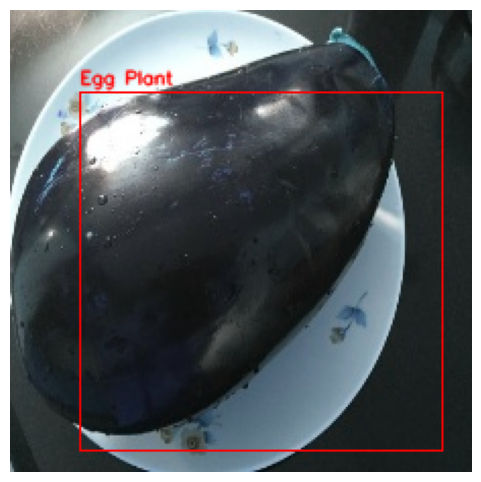

1/1 [==============================] - 0s 364ms/step


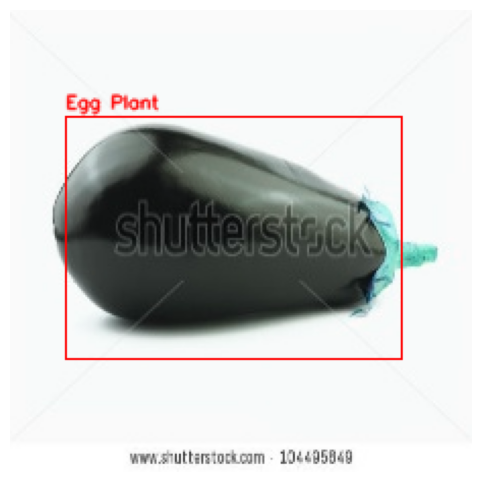

1/1 [==============================] - 0s 483ms/step


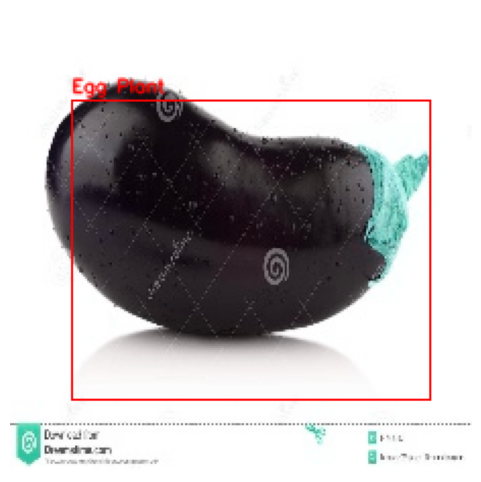

1/1 [==============================] - 0s 379ms/step


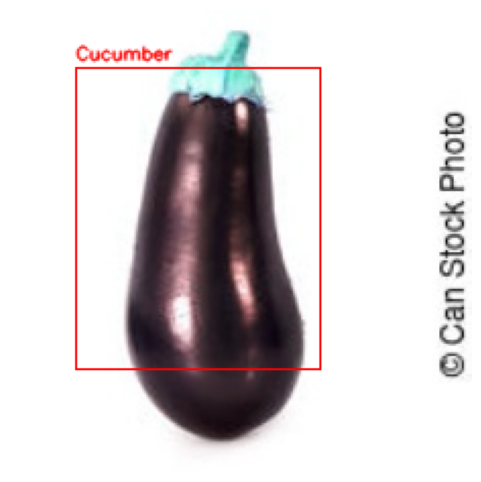

1/1 [==============================] - 0s 407ms/step


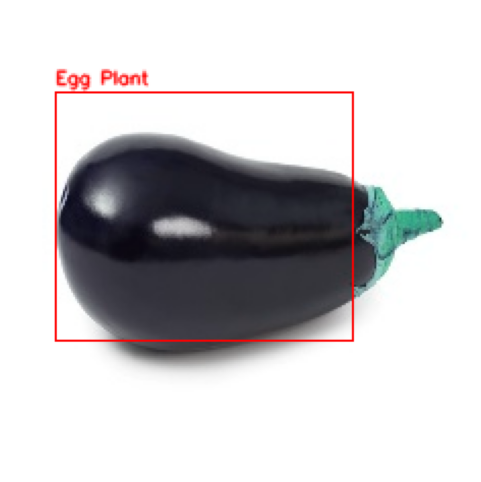

1/1 [==============================] - 0s 334ms/step


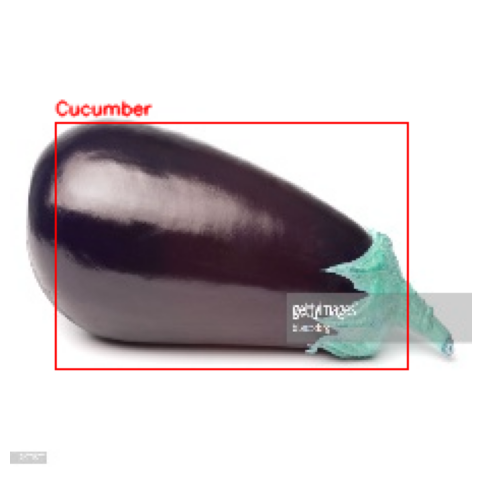

In [21]:
for i in range(40, 46):
    path = f'training_images/eggplant_{i}.jpg'
    predict(path, model, False)